# Process of Benchmarking data

In [1]:
from functions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

In [3]:
n_qubit = 2
noise_model = 'depolarising_noise'

epsilon = 0.01
path = os.path.join( os.getcwd(), 'output_storage', noise_model, 'epsilon' + str(epsilon) )

In [4]:
machine_title = '2q-qvm'

In [5]:
avg_fdlty_dict = {}
err_fdlty_dict = {}
ordered_layers_dict = {}

In [6]:
def capture_bench_dataframe(path):
    dataframe = pd.read_csv(os.path.join(path, '{}.csv'.format(machine_title) ) )
    dataframe = dataframe[dataframe['number of qubits'] == n_qubit]
    return dataframe

def capture_bench_arrays(dataframe, version_name):
    dataframe = dataframe[ dataframe['protocol name'] == version_name ]
    ordered_layers = dataframe['circuit depth']
    avg_fdlty_arr = dataframe['average of fidelity']
    err_fdlty_arr = dataframe['error of fidelity']
    return ordered_layers, avg_fdlty_arr, err_fdlty_arr

In [7]:
df = capture_bench_dataframe(path)
bench_versions = df['protocol name'].unique()
for version in bench_versions:
    avg_fdlty_dict[version] = {}
    err_fdlty_dict[version] = {}
    ordered_layers_dict[version] = {}

    try:
        ordered_layers, avg_fdlty_arr, err_fdlty_arr = capture_bench_arrays(df, version)
        avg_fdlty_dict[version].update({epsilon:avg_fdlty_arr})
        err_fdlty_dict[version].update({epsilon:err_fdlty_arr})
        ordered_layers_dict[version].update({epsilon:ordered_layers})
    except:
        pass

In [8]:
df.head()

,date,number of qubits,number of sequences,number of shots,protocol name,circuit depth,average of fidelity,error of fidelity
0,2023-01-05,2,50,50,standard,1,0.9908,0.012781
1,2023-01-05,2,50,50,standard,3,0.9624,0.028182
2,2023-01-05,2,50,50,standard,5,0.9396,0.035211
3,2023-01-05,2,50,50,standard,7,0.8980,0.046690
4,2023-01-05,2,50,50,standard,9,0.8876,0.050262


In [9]:
# avg_fdlty_dict

In [10]:
def plot_bench_arrays(axes, version, epsilon):
    popt, pcov = extrapolate_decay_func( ordered_layers_dict[version][epsilon],
                                        avg_fdlty_dict[version][epsilon], err_fdlty_dict[version][epsilon])
    r = decay_param(popt[0], n_qubit)
    between_layers = np.arange(ordered_layers_dict[version][epsilon].min(),ordered_layers_dict[version][epsilon].max(),1).astype('int')
    
    axes.errorbar(ordered_layers_dict[version][epsilon], avg_fdlty_dict[version][epsilon],
                yerr = err_fdlty_dict[version][epsilon],
                fmt = 'o', color = 'k')
    axes.plot(between_layers, decay_func(between_layers, *popt),
              label = version + r': ${1}*{0}^m+{2}$'.format(*np.round(popt,5)))
    return


In [11]:
bench_versions

array(['standard', 'stabilizer', 'native', 'random_def_unitaries',
       'native_conditional', 'conditional_universal_circuit'],
      dtype=object)

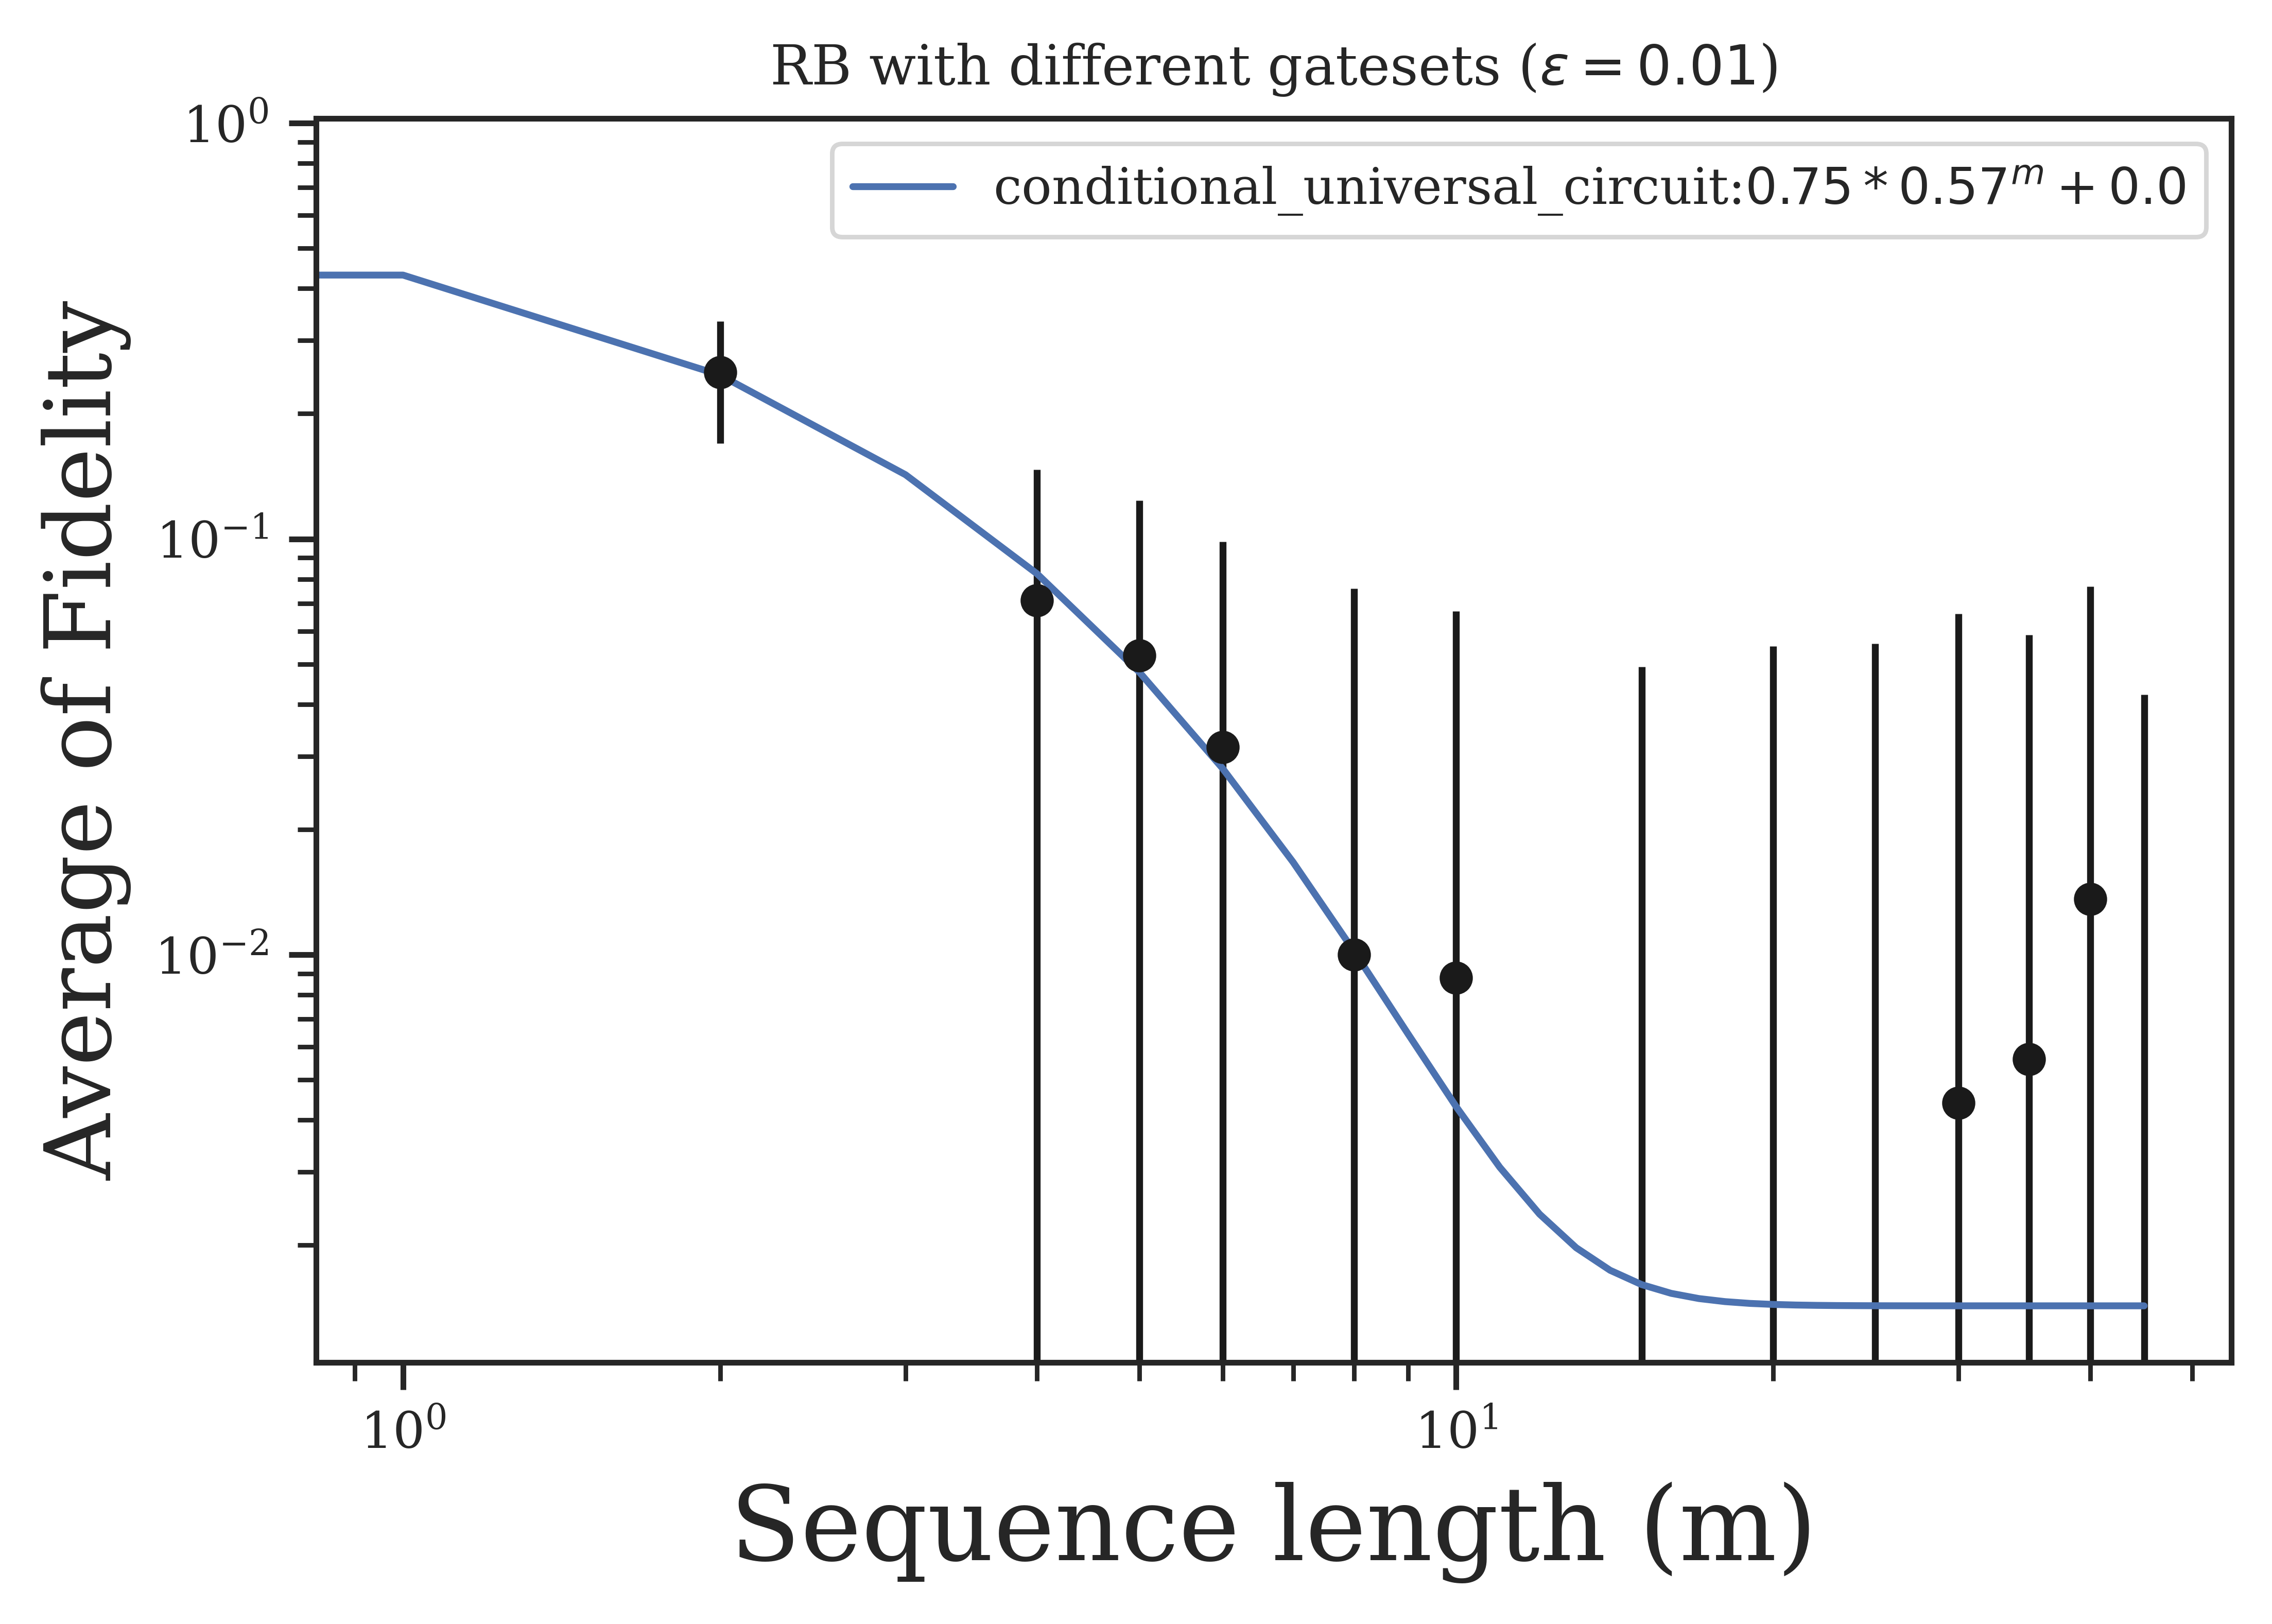

In [18]:
fig = plt.figure(dpi = 800)
ax = fig.add_subplot()

epsilon = 0.01

for version in ['conditional_universal_circuit']:
#     plot_bench_arrays(ax, version, epsilon)
    plot_decay(ordered_layers_dict[version][epsilon][1:], avg_fdlty_dict[version][epsilon][1:] - 0.25,
               err_fdlty_dict[version][epsilon][1:], label = version, axes = ax)

plt.loglog()
ax.set_xlabel('Sequence length (m)', fontsize=18)
ax.set_ylabel('Average of Fidelity', fontsize=16)
ax.set_title(r'RB with different gatesets ($\epsilon = {}$)'.format(epsilon))

plt.legend()

fig.savefig(os.path.join(path, 'RB_comparison'+'.png'))
